<a href="https://colab.research.google.com/github/DasarnaBusi/VISION-TO-VERSE-AN-IMAGE-CAPTIONING-MODEL/blob/main/final_review_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import random
from google.colab import drive

In [ ]:

image_dir = '/content/drive/MyDrive/captions/images/'
caption_file = '/content/drive/MyDrive/captions/caption.txt'
feature_dir = '/content/drive/MyDrive/features/'
os.makedirs(feature_dir, exist_ok=True)

In [ ]:

try:
    captions_df = pd.read_csv(caption_file, on_bad_lines='warn')
except pd.errors.ParserError as e:
    print(f"Error parsing CSV: {e}")
    print("Attempting to load with manual parsing...")
    captions = {}
    with open(caption_file, 'r') as f:
        lines = f.readlines()
        header = lines[0].strip().split(',')
        if header != ['image', 'caption']:
            print("Invalid header. Expected 'image,caption'.")
            raise ValueError("Invalid CSV header")
        for i, line in enumerate(lines[1:], start=2):
            try:
                parts = line.strip().split(',', 1)
                if len(parts) != 2:
                    print(f"Skipping line {i}: Invalid format - {line.strip()}")
                    continue
                img, cap = parts
                if img not in captions:
                    captions[img] = []
                captions[img].append('<start> ' + cap + ' <end>')
            except Exception as e:
                print(f"Error processing line {i}: {line.strip()} - {e}")
                continue
else:
    captions = {}
    for _, row in captions_df.iterrows():
        img = row['image']
        cap = row['caption']
        if img not in captions:
            captions[img] = []
        captions[img].append('<start> ' + cap + ' <end>')

<ipython-input-9-0474df1507bc>:2: ParserWarning: Skipping line 4: expected 2 fields, saw 3
Skipping line 6: expected 2 fields, saw 3
Skipping line 21: expected 2 fields, saw 3
Skipping line 26: expected 2 fields, saw 4
Skipping line 66: expected 2 fields, saw 4
Skipping line 76: expected 2 fields, saw 3
Skipping line 77: expected 2 fields, saw 3
Skipping line 78: expected 2 fields, saw 3
Skipping line 80: expected 2 fields, saw 3
Skipping line 81: expected 2 fields, saw 3
Skipping line 95: expected 2 fields, saw 3
Skipping line 99: expected 2 fields, saw 3
Skipping line 101: expected 2 fields, saw 3
Skipping line 145: expected 2 fields, saw 3
Skipping line 150: expected 2 fields, saw 3
Skipping line 153: expected 2 fields, saw 3
Skipping line 290: expected 2 fields, saw 3
Skipping line 295: expected 2 fields, saw 3
Skipping line 368: expected 2 fields, saw 3
Skipping line 455: expected 2 fields, saw 3
Skipping line 508: expected 2 fields, saw 3
Skipping line 524: expected 2 fields, saw

In [ ]:

all_captions = []
for img in captions:
    for cap in captions[img]:
        all_captions.append(cap)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(cap.split()) for cap in all_captions)

In [ ]:

with open(os.path.join(feature_dir, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:

base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [ ]:
def extract_features(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [ ]:

image_features = {}
for img_name in captions.keys():
    img_path = os.path.join(image_dir, img_name)
    feature_path = os.path.join(feature_dir, img_name + '.npy')
    if not os.path.exists(feature_path):
        feature = extract_features(img_path)
        np.save(feature_path, feature)
    image_features[img_name] = np.load(feature_path, allow_pickle=True)

In [ ]:

def data_generator(captions, image_features, tokenizer, max_length, vocab_size, batch_size=32):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for img_name, caption_list in captions.items():
            for caption in caption_list:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(image_features[img_name][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    n += 1
                    if n == batch_size:

                        yield ((np.array(X1), np.array(X2)), np.array(y))
                        X1, X2, y = [], [], []
                        n = 0

In [ ]:

image_input = Input(shape=(2048,))
img_dropout = Dropout(0.5)(image_input)
img_dense = Dense(256, activation='relu')(img_dropout)

sequence_input = Input(shape=(max_length,))
seq_embedding = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
seq_dropout = Dropout(0.5)(seq_embedding)
seq_lstm = LSTM(256)(seq_dropout)

decoder = add([img_dense, seq_lstm])
decoder_dense1 = Dense(256, activation='relu')(decoder)
output = Dense(vocab_size, activation='softmax')(decoder_dense1)

model = Model(inputs=[image_input, sequence_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))

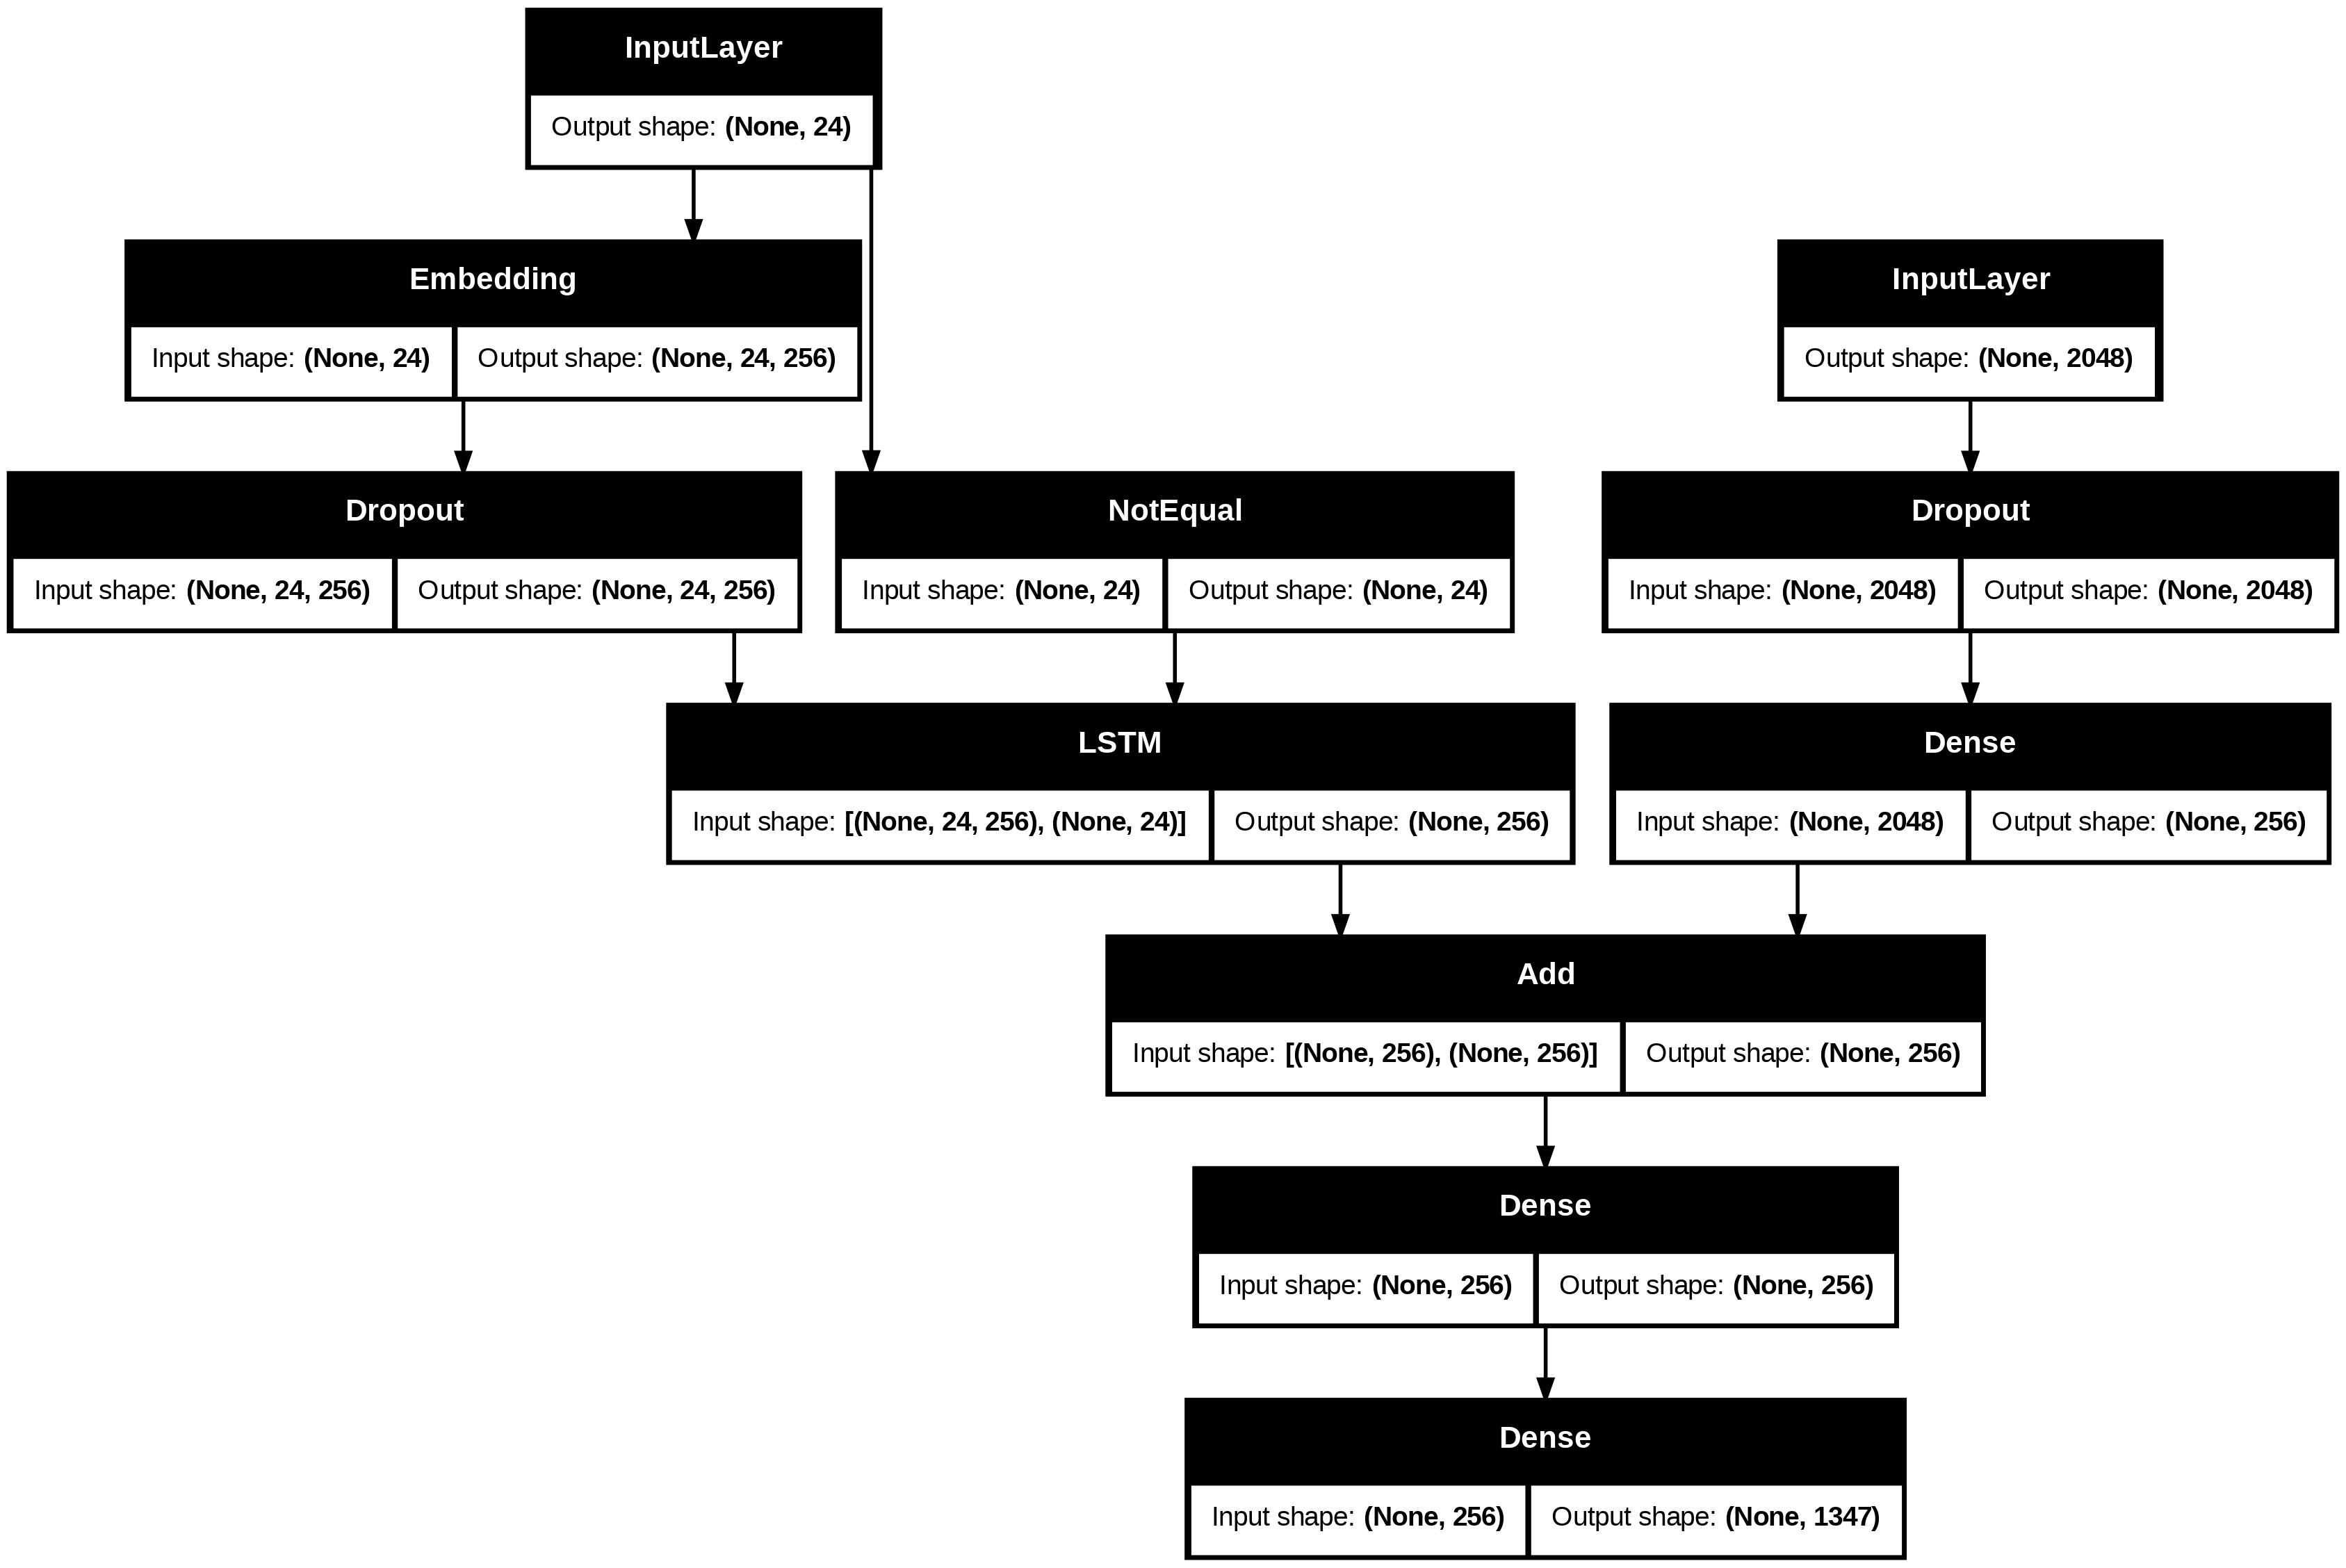

In [ ]:

plot_model(model, to_file=os.path.join(feature_dir, 'model.png'), show_shapes=True)

In [ ]:

import tensorflow as tf
batch_size = 32
steps = sum(len(caps) for caps in captions.values()) // batch_size
generator = data_generator(captions, image_features, tokenizer, max_length, vocab_size, batch_size)


output_signature = (
    (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)


dataset = tf.data.Dataset.from_generator(
    lambda: generator,
    output_signature=output_signature
)

model.fit(dataset, epochs=50, steps_per_epoch=steps, verbose=1)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - loss: 5.8464
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - loss: 5.0848
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 5.3332
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - loss: 4.9811
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 4.8531
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - loss: 4.8926
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 5.2519
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 5.2848
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - loss: 5.2629
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - loss: 4.9362
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - loss: 5.1934
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 5.0628
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 4.6574
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 4.2832
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step -

In [ ]:

model.save(os.path.join(feature_dir, 'caption_model.h5'))

In [ ]:

def beam_search(model, tokenizer, image_feature, max_length, beam_width=3):
    start_token = tokenizer.texts_to_sequences(['<start>'])[0][0]
    sequences = [[start_token], [start_token], [start_token]]
    scores = [0, 0, 0]

    for _ in range(max_length):
        all_candidates = []
        for i in range(len(sequences)):
            seq = pad_sequences([sequences[i]], maxlen=max_length)
            yhat = model.predict([image_feature, seq], verbose=0)
            word_probs = yhat[0]
            for j in range(len(word_probs)):
                candidate = sequences[i] + [j]
                candidate_score = scores[i] - np.log(word_probs[j] + 1e-8)
                all_candidates.append((candidate, candidate_score))

        ordered = sorted(all_candidates, key=lambda x: x[1])
        sequences = [ordered[i][0] for i in range(beam_width)]
        scores = [ordered[i][1] for i in range(beam_width)]

        if tokenizer.index_word.get(sequences[0][-1]) == '<end>':
            break

    caption = ' '.join(tokenizer.index_word.get(idx, '<unk>') for idx in sequences[0])
    return caption.replace('<start> ', '').replace(' <end>', '')

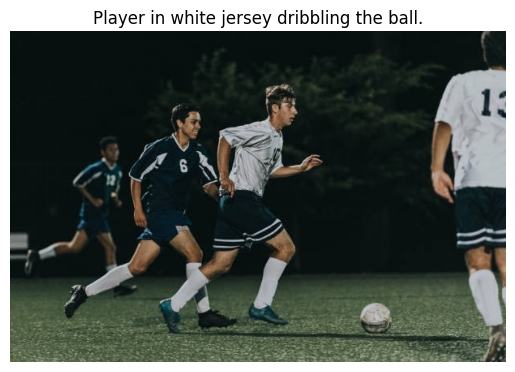

In [ ]:

random_img = random.choice(list(captions.keys()))
if random_img in image_features:
    img_path = os.path.join(image_dir, random_img)
    image_feature = image_features[random_img]
    actual_captions = captions[random_img]
    predicted_caption = beam_search(model, tokenizer, image_feature, max_length)

    image = load_img(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{actual_captions[0].replace('<start> ', '').replace(' <end>', '')}")
    plt.savefig(os.path.join(feature_dir, 'result.png'))
    plt.show()
else:
    print(f"Features for {random_img} not found, please ensure feature extraction completed successfully.")

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:


import numpy as np
import pandas as pd

files=[]
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/captions'):

    for filename in filenames:

        files.append(os.path.join(dirname, filename))


In [ ]:

import os, time
from tqdm import tqdm
import glob


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from IPython import display

In [ ]:


images='/content/drive/MyDrive/captions/images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 300


In [ ]:
all_imgs

['/content/drive/MyDrive/captions/images/174.jpg',
 '/content/drive/MyDrive/captions/images/173.jpg',
 '/content/drive/MyDrive/captions/images/151.jpg',
 '/content/drive/MyDrive/captions/images/152.jpg',
 '/content/drive/MyDrive/captions/images/153.jpg',
 '/content/drive/MyDrive/captions/images/169.jpg',
 '/content/drive/MyDrive/captions/images/167.jpg',
 '/content/drive/MyDrive/captions/images/164.jpg',
 '/content/drive/MyDrive/captions/images/165.jpg',
 '/content/drive/MyDrive/captions/images/158.jpg',
 '/content/drive/MyDrive/captions/images/163.jpg',
 '/content/drive/MyDrive/captions/images/159.jpg',
 '/content/drive/MyDrive/captions/images/160.jpg',
 '/content/drive/MyDrive/captions/images/157.jpg',
 '/content/drive/MyDrive/captions/images/162.jpg',
 '/content/drive/MyDrive/captions/images/168.jpg',
 '/content/drive/MyDrive/captions/images/170.jpg',
 '/content/drive/MyDrive/captions/images/166.jpg',
 '/content/drive/MyDrive/captions/images/161.jpg',
 '/content/drive/MyDrive/captio

In [ ]:


text_file = "/content/drive/MyDrive/captions/caption.txt"

def load_doc(filename):

    file = open(filename)
    text = file.read()
    file.close()

    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1.jpg,A player in blue attempts a bicycle kick while a player in red watches.
1.jpg,A footballer in blue is striking the ball mid-air as an opponent in red approaches.
1.jpg,A player in blue performs an acrobatic kick, while a player in red runs toward him.
1.jpg,A football match scene


In [ ]:
img = '/content/drive/MyDrive/captions/images'
def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(img+'/'+im_id)
    return keys,key_paths, values

In [ ]:
all_img_id, all_img_vector, annotations = get_img_ids_and_captions(doc)
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])
df.head(10)

,ID,Path,Captions
0,1.jpg,/content/drive/MyDrive/captions/images/1.jpg,A player in blue attempts a bicycle kick while...
1,1.jpg,/content/drive/MyDrive/captions/images/1.jpg,A footballer in blue is striking the ball mid-...
2,1.jpg,/content/drive/MyDrive/captions/images/1.jpg,"A player in blue performs an acrobatic kick, w..."
3,1.jpg,/content/drive/MyDrive/captions/images/1.jpg,A football match scene with a player in blue e...
4,1.jpg,/content/drive/MyDrive/captions/images/1.jpg,A player in blue leaps into the air to kick th...
5,2.jpg,/content/drive/MyDrive/captions/images/2.jpg,A player in a yellow jersey dribbles the ball ...
6,2.jpg,/content/drive/MyDrive/captions/images/2.jpg,A footballer in yellow moves forward as an opp...
7,2.jpg,/content/drive/MyDrive/captions/images/2.jpg,A player in red is on the ground after a slidi...
8,2.jpg,/content/drive/MyDrive/captions/images/2.jpg,A football match scene where a player in yello...
9,2.jpg,/content/drive/MyDrive/captions/images/2.jpg,A player in red stretches out for a tackle as ...


In [ ]:
len (annotations)


1500

In [ ]:
type (annotations)

list

In [ ]:
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_imgs)))

Total captions present in the dataset: 1500
Total images present in the dataset: 300


In [ ]:
def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)

        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)

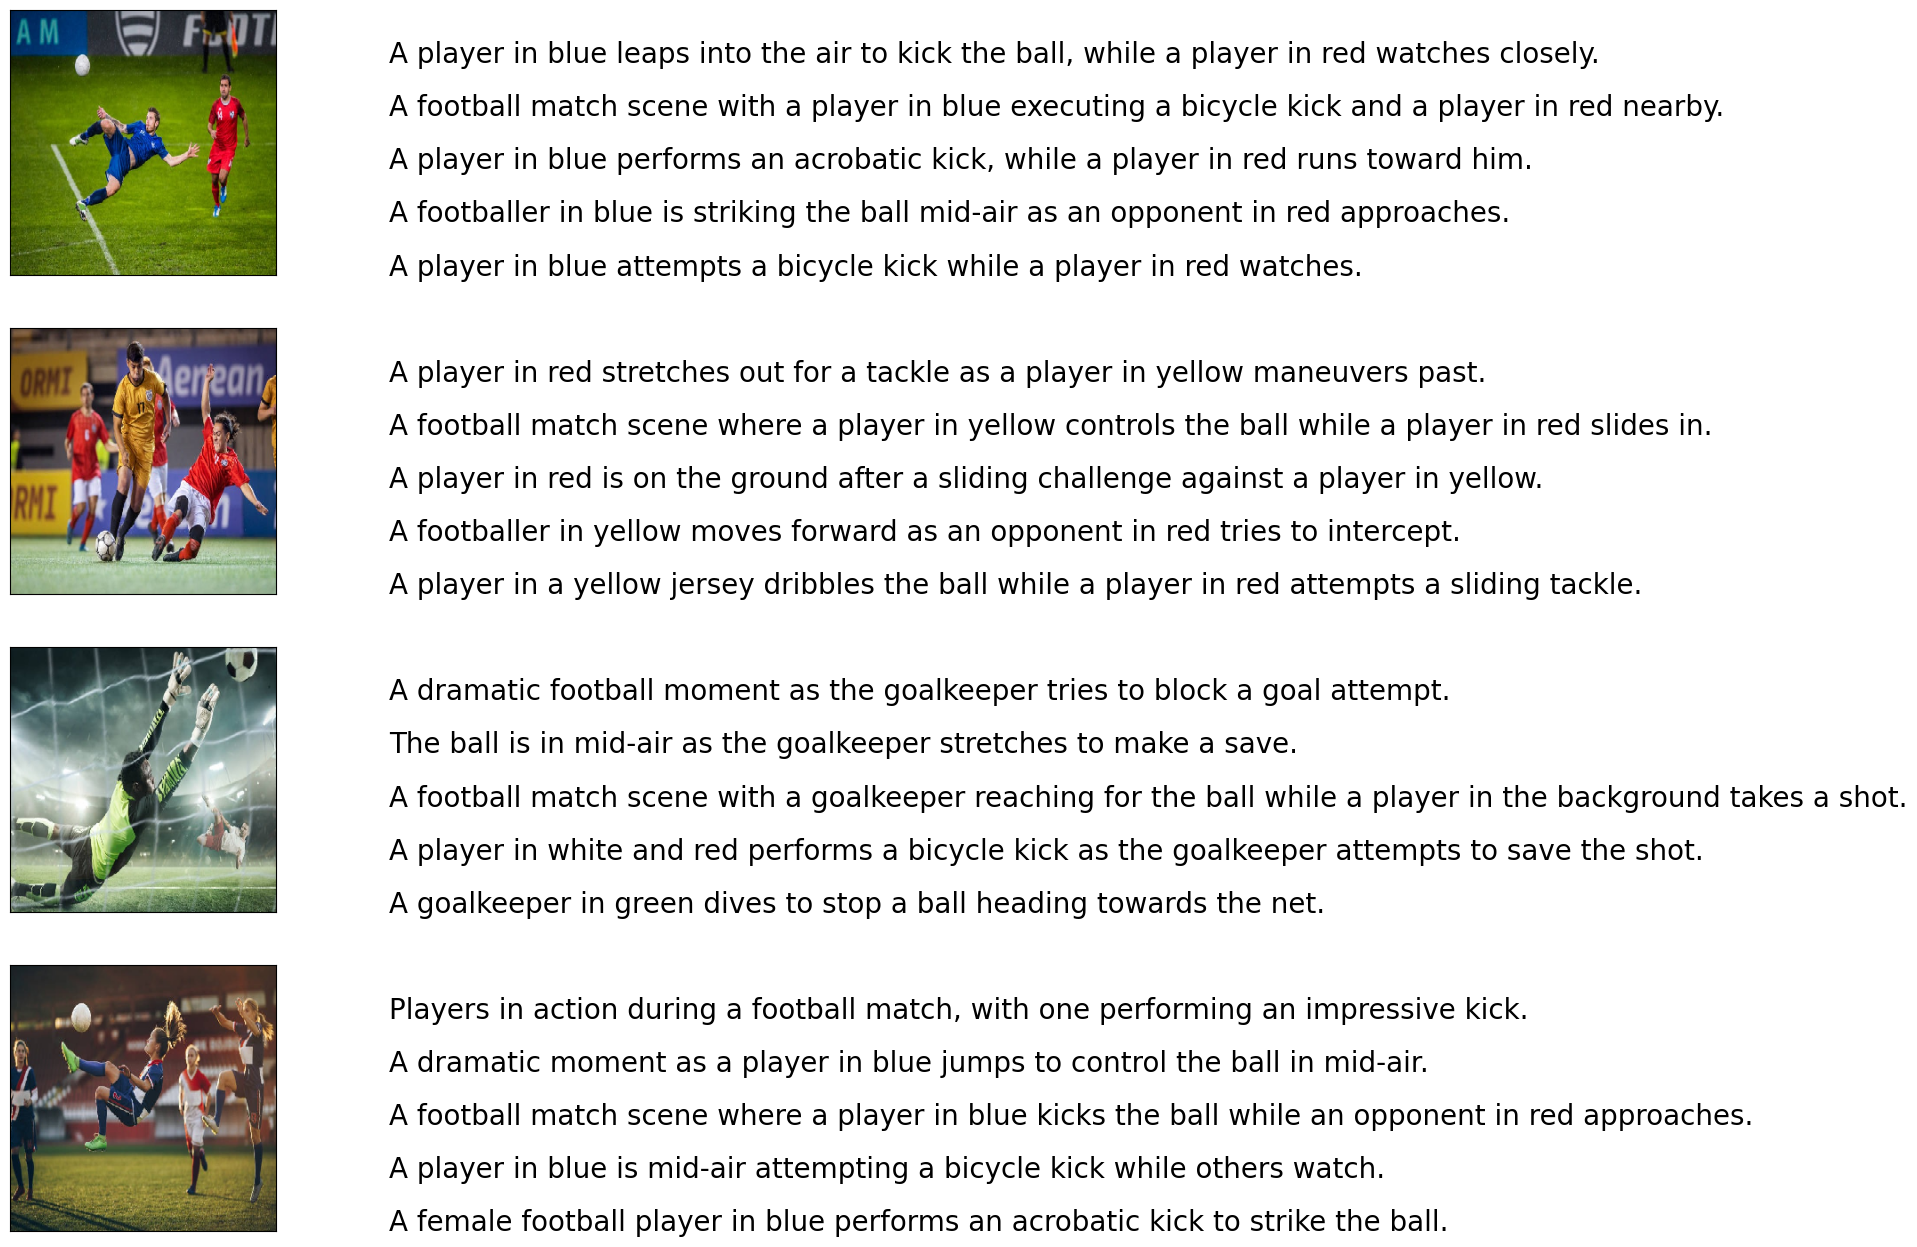

In [ ]:

fig = plt.figure(figsize=(10,20))
count = 1

for Path in df[:20].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

In [ ]:
print(df['Captions'])

0       A player in blue attempts a bicycle kick while...
1       A footballer in blue is striking the ball mid-...
2       A player in blue performs an acrobatic kick, w...
3       A football match scene with a player in blue e...
4       A player in blue leaps into the air to kick th...
                              ...                        
1495    The kids were enjoying the kabaddi match witho...
1496    A young raider stretched forward, trying to to...
1497    The defenders surrounded the raider, ready to ...
1498    The match was played barefoot on the grass in ...
1499    The children were focused and excited while pl...
Name: Captions, Length: 1500, dtype: object


In [ ]:

annotations=df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")

all_img_path=list(df["Path"])

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 1500
Total images present in the dataset: 1500


In [ ]:


def create_vocabulary(data):
  vocab = []
  for captions in data.Captions.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [ ]:
from collections import Counter

vocabulary = create_vocabulary(df)#write your code here

val_count=Counter(vocabulary)
val_count

Vocabulary Size : 2087


Counter({'A': 472,
         'player': 311,
         'in': 574,
         'blue': 103,
         'attempts': 47,
         'a': 693,
         'bicycle': 6,
         'kick': 16,
         'while': 169,
         'red': 109,
         'watches.': 1,
         'footballer': 2,
         'is': 129,
         'striking': 3,
         'the': 1321,
         'ball': 120,
         'mid-air': 20,
         'as': 265,
         'an': 99,
         'opponent': 13,
         'approaches.': 4,
         'performs': 10,
         'acrobatic': 4,
         'kick,': 2,
         'runs': 3,
         'toward': 5,
         'him.': 17,
         'football': 23,
         'match': 71,
         'scene': 5,
         'with': 172,
         'executing': 3,
         'and': 229,
         'nearby.': 2,
         'leaps': 19,
         'into': 14,
         'air': 7,
         'to': 481,
         'ball,': 5,
         'watches': 20,
         'closely.': 5,
         'yellow': 30,
         'jersey': 86,
         'dribbles': 11,
         'slidi

In [ ]:
top30= val_count.most_common(30)

top30

[('the', 1321),
 ('a', 693),
 ('in', 574),
 ('to', 481),
 ('A', 472),
 ('The', 426),
 ('player', 311),
 ('as', 265),
 ('on', 235),
 ('and', 229),
 ('for', 181),
 ('with', 172),
 ('while', 169),
 ('players', 164),
 ('is', 129),
 ('of', 122),
 ('ball', 120),
 ('red', 109),
 ('raider', 104),
 ('blue', 103),
 ('an', 99),
 ('his', 99),
 ('basketball', 97),
 ('game', 92),
 ('moment', 89),
 ('jersey', 86),
 ('volleyball', 81),
 ('badminton', 79),
 ('team', 77),
 ('cricket', 74)]

In [ ]:


df_word = pd.DataFrame.from_dict(val_count, orient = 'index')
df_word = df_word.sort_values(by = [0], ascending=False).reset_index()
df_word = df_word.rename(columns={'index':'word', 0:'count'})

df_word.head()

,word,count
0,the,1321
1,a,693
2,in,574
3,to,481
4,A,472


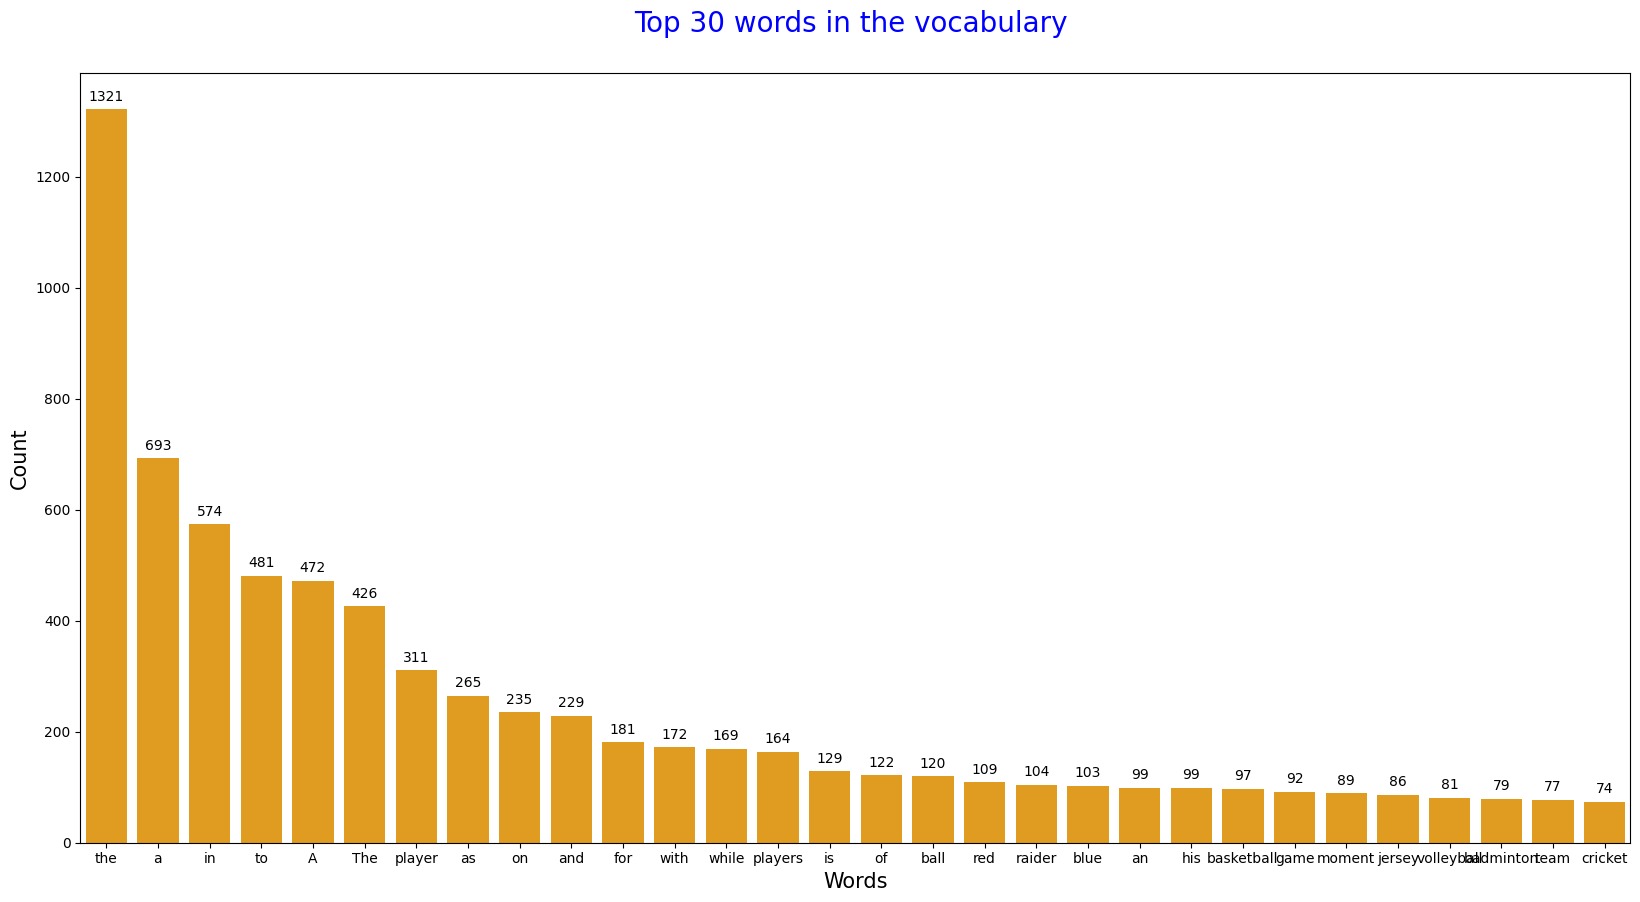

In [ ]:
words = []
counts = []
for word_count in top30 :
    words.append(word_count[0])
    counts.append(word_count[1])

plt.figure(figsize=(20,10))
plt.title('Top 30 words in the vocabulary \n', color='b',size= 20)
plt.xlabel('Words',size=15)
plt.ylabel('Count', size=15)
plot = sns.barplot(x=words, y=counts, color='orange')
for p in plot.patches:
    plot.annotate(format(int(p.get_height())),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.show()

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')


tokenizer.fit_on_texts(annotations)

tokensized_text = tokenizer.texts_to_sequences(annotations)

In [ ]:
tokensized_text[:5]

[[3, 5, 8, 6, 25, 51, 5, 380, 90, 16, 5, 8, 6, 24, 129, 4],
 [3, 5, 699, 6, 25, 19, 571, 2, 13, 72, 62, 9, 20, 156, 6, 24, 245, 4],
 [3, 5, 8, 6, 25, 246, 20, 479, 90, 16, 5, 8, 6, 24, 480, 429, 84, 4],
 [3,
  5,
  59,
  17,
  430,
  15,
  5,
  8,
  6,
  25,
  572,
  5,
  380,
  90,
  12,
  5,
  8,
  6,
  24,
  573,
  4],
 [3, 5, 8, 6, 25, 146, 192, 2, 62, 7, 90, 2, 13, 16, 5, 8, 6, 24, 129, 166, 4]]

In [ ]:
annotations[:5]

,Captions
0,<start> A player in blue attempts a bicycle ki...
1,<start> A footballer in blue is striking the b...
2,<start> A player in blue performs an acrobatic...
3,<start> A football match scene with a player i...
4,<start> A player in blue leaps into the air to...


In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
tokensized_text = tokenizer.texts_to_sequences(annotations)

In [ ]:
tokenizer.word_counts

OrderedDict([('<start>', 1500),
             ('a', 1165),
             ('player', 357),
             ('in', 583),
             ('blue', 107),
             ('attempts', 47),
             ('bicycle', 6),
             ('kick', 28),
             ('while', 169),
             ('red', 111),
             ('watches', 21),
             ('<end>', 1500),
             ('footballer', 2),
             ('is', 129),
             ('striking', 3),
             ('the', 1747),
             ('ball', 191),
             ('mid', 34),
             ('air', 41),
             ('as', 265),
             ('an', 127),
             ('opponent', 17),
             ('approaches', 10),
             ('performs', 10),
             ('acrobatic', 4),
             ('runs', 4),
             ('toward', 5),
             ('him', 29),
             ('football', 42),
             ('match', 162),
             ('scene', 5),
             ('with', 175),
             ('executing', 3),
             ('and', 229),
             ('nearby', 3),


In [ ]:
tokenizer.index_word

{1: '<unk>',
 2: 'the',
 3: '<start>',
 4: '<end>',
 5: 'a',
 6: 'in',
 7: 'to',
 8: 'player',
 9: 'as',
 10: 'on',
 11: 'players',
 12: 'and',
 13: 'ball',
 14: 'for',
 15: 'with',
 16: 'while',
 17: 'match',
 18: 'game',
 19: 'is',
 20: 'an',
 21: 'of',
 22: 'raider',
 23: 'basketball',
 24: 'red',
 25: 'blue',
 26: 'shot',
 27: 'his',
 28: 'moment',
 29: 'court',
 30: 'defenders',
 31: 'team',
 32: 'two',
 33: 'jersey',
 34: 'volleyball',
 35: 'badminton',
 36: 'cricket',
 37: 'field',
 38: 'from',
 39: 'action',
 40: 'during',
 41: 'intense',
 42: 'ready',
 43: 'after',
 44: 'defender',
 45: 'net',
 46: 'block',
 47: 'their',
 48: 'runner',
 49: 'focused',
 50: 'at',
 51: 'attempts',
 52: 'white',
 53: 'jerseys',
 54: 'prepares',
 55: 'hockey',
 56: 'play',
 57: 'forward',
 58: 'under',
 59: 'football',
 60: 'stretches',
 61: 'high',
 62: 'air',
 63: 'tries',
 64: 'background',
 65: 'one',
 66: 'near',
 67: 'out',
 68: 'young',
 69: 'teams',
 70: 'hoop',
 71: 'he',
 72: 'mid',
 73:

In [ ]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

<unk>
<pad>


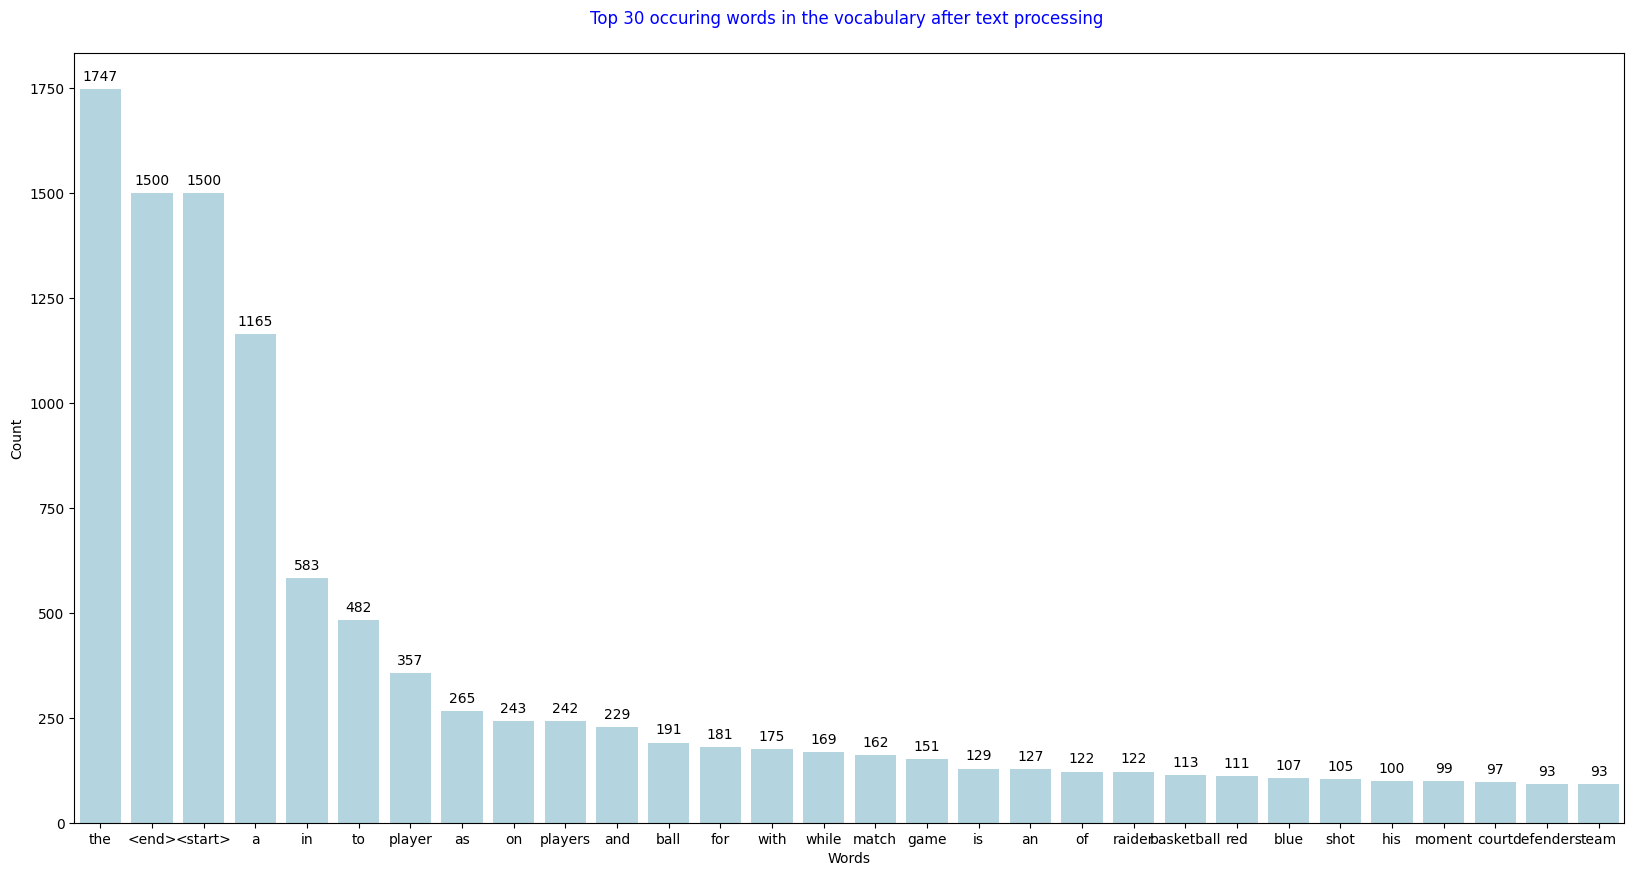

In [ ]:
tokenizer_df = pd.DataFrame([tokenizer.word_counts]).transpose().reset_index()

top30words = tokenizer_df.sort_values(by=0,ascending=False).head(30).reset_index(drop=True).rename(columns={"index":"words",0:"counts"})

plt.figure(figsize=(20,10))
plt.title('Top 30 occuring words in the vocabulary after text processing \n',color='b')
plt.xlabel('Words')
plt.ylabel('Count')
plot=sns.barplot(x=top30words.words,y=top30words.counts, color='lightblue')

for p in plot.patches:
    plot.annotate(format(int(p.get_height())),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.show()

In [ ]:
def max_len(input):
    listofLength = [len(x) for x in input]
    return max(listofLength)

max_l = max_len(tokensized_text)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(tokensized_text,padding='post',maxlen=max_l)


print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(1500, 24)


In [ ]:
cap_vector

array([[  3,   5,   8, ...,   0,   0,   0],
       [  3,   5, 699, ...,   0,   0,   0],
       [  3,   5,   8, ...,   0,   0,   0],
       ...,
       [  3,   2,  30, ...,   0,   0,   0],
       [  3,   2,  17, ...,   0,   0,   0],
       [  3,   2, 295, ...,   0,   0,   0]], dtype=int32)

In [ ]:
all_imgs

['/content/drive/MyDrive/captions/images/174.jpg',
 '/content/drive/MyDrive/captions/images/173.jpg',
 '/content/drive/MyDrive/captions/images/151.jpg',
 '/content/drive/MyDrive/captions/images/152.jpg',
 '/content/drive/MyDrive/captions/images/153.jpg',
 '/content/drive/MyDrive/captions/images/169.jpg',
 '/content/drive/MyDrive/captions/images/167.jpg',
 '/content/drive/MyDrive/captions/images/164.jpg',
 '/content/drive/MyDrive/captions/images/165.jpg',
 '/content/drive/MyDrive/captions/images/158.jpg',
 '/content/drive/MyDrive/captions/images/163.jpg',
 '/content/drive/MyDrive/captions/images/159.jpg',
 '/content/drive/MyDrive/captions/images/160.jpg',
 '/content/drive/MyDrive/captions/images/157.jpg',
 '/content/drive/MyDrive/captions/images/162.jpg',
 '/content/drive/MyDrive/captions/images/168.jpg',
 '/content/drive/MyDrive/captions/images/170.jpg',
 '/content/drive/MyDrive/captions/images/166.jpg',
 '/content/drive/MyDrive/captions/images/161.jpg',
 '/content/drive/MyDrive/captio

In [ ]:


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

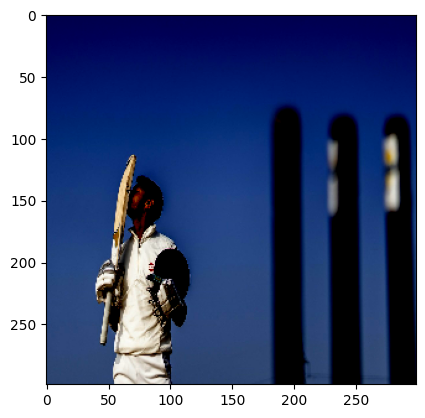

In [ ]:
plt.imshow(load_image(all_imgs[4])[0])
plt.show()

In [ ]:

encode_train_set = sorted(set(all_img_vector))

feature_dict = {}
image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)


image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)


In [ ]:
image_data_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input =image_model.input

hidden_layer =  image_model.layers[-1].output

image_features_extract_model =  keras.Model(new_input, hidden_layer)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
for image,path in tqdm(image_data_set):
    features = image_features_extract_model(image)
    features = tf.reshape(features,(features.shape[0],-1,features.shape[3]))
    for batch_features, p in zip(features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_features.numpy()

100%|██████████| 10/10 [02:16<00:00, 13.62s/it]


In [ ]:
batch_features.shape

TensorShape([64, 2048])

In [ ]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,
                                                                    cap_vector,
                                                                        test_size=0.2,
                                                                        random_state=42)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 1200
Testing data for images: 300
Training data for Captions: 1200
Testing data for Captions: 300


In [ ]:
def map_func(image_name,capt):
  img_tensor = feature_dict[image_name.decode('utf-8')]
  return img_tensor, capt

In [ ]:
def gen_dataset(images_data, captions_data, BATCH_SIZE =32):

    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(32, 64, 2048)
(32, 24)


In [ ]:
embedding_dim = 256
units = 512

vocab_size = 5001

train_num_steps = len(path_train)

test_num_steps = len(path_test)

In [ ]:
train_num_steps

1200

In [ ]:
test_num_steps

300

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.leakyrelu = tf.keras.layers.LeakyReLU(alpha=0.01)

    def call(self, features):
        features = self.dense(features)
        features = self.leakyrelu(features)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
encoder

<Encoder name=encoder, built=False>

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):

        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.embed(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)
        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape))
print('Predcitions shape from Decoder: {}'.format(predictions.shape))
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


In [ ]:
optimizer =keras.optimizers.Adam()
loss_object =keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./Checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))


    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0

    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps


    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.094, & test loss is 0.091
Time taken for 1 epoch 311.3258240222931 sec

Test loss has been reduced from 100.000 to 0.091


 13%|█▎        | 2/15 [07:58<49:05, 226.60s/it]  

For epoch: 2, the train loss is 0.083, & test loss is 0.082
Time taken for 1 epoch 166.9365153312683 sec

Test loss has been reduced from 0.091 to 0.082


 20%|██        | 3/15 [10:43<39:41, 198.42s/it]

For epoch: 3, the train loss is 0.074, & test loss is 0.072
Time taken for 1 epoch 164.73758363723755 sec

Test loss has been reduced from 0.082 to 0.072


 27%|██▋       | 4/15 [13:35<34:29, 188.11s/it]

For epoch: 4, the train loss is 0.066, & test loss is 0.065
Time taken for 1 epoch 172.10694217681885 sec

Test loss has been reduced from 0.072 to 0.065


 33%|███▎      | 5/15 [16:26<30:17, 181.72s/it]

For epoch: 5, the train loss is 0.060, & test loss is 0.060
Time taken for 1 epoch 170.23765087127686 sec

Test loss has been reduced from 0.065 to 0.060


 40%|████      | 6/15 [19:13<26:31, 176.81s/it]

For epoch: 6, the train loss is 0.055, & test loss is 0.055
Time taken for 1 epoch 167.09606623649597 sec

Test loss has been reduced from 0.060 to 0.055
For epoch: 7, the train loss is 0.051, & test loss is 0.050
Time taken for 1 epoch 162.64292693138123 sec

Test loss has been reduced from 0.055 to 0.050


 53%|█████▎    | 8/15 [24:51<20:13, 173.29s/it]

For epoch: 8, the train loss is 0.047, & test loss is 0.046
Time taken for 1 epoch 175.33784365653992 sec

Test loss has been reduced from 0.050 to 0.046
For epoch: 9, the train loss is 0.043, & test loss is 0.043
Time taken for 1 epoch 166.6047945022583 sec

Test loss has been reduced from 0.046 to 0.043


 60%|██████    | 9/15 [27:38<17:07, 171.27s/it]

For epoch: 10, the train loss is 0.040, & test loss is 0.040
Time taken for 1 epoch 173.27630805969238 sec

Test loss has been reduced from 0.043 to 0.040


 73%|███████▎  | 11/15 [33:20<11:22, 170.71s/it]

For epoch: 11, the train loss is 0.037, & test loss is 0.036
Time taken for 1 epoch 167.68202090263367 sec

Test loss has been reduced from 0.040 to 0.036


 80%|████████  | 12/15 [36:15<08:36, 172.15s/it]

For epoch: 12, the train loss is 0.034, & test loss is 0.034
Time taken for 1 epoch 175.28514862060547 sec

Test loss has been reduced from 0.036 to 0.034
For epoch: 13, the train loss is 0.032, & test loss is 0.031
Time taken for 1 epoch 154.26550388336182 sec

Test loss has been reduced from 0.034 to 0.031


 93%|█████████▎| 14/15 [41:26<02:43, 163.57s/it]

For epoch: 14, the train loss is 0.029, & test loss is 0.029
Time taken for 1 epoch 155.88911819458008 sec

Test loss has been reduced from 0.031 to 0.029


100%|██████████| 15/15 [44:04<00:00, 176.31s/it]

For epoch: 15, the train loss is 0.027, & test loss is 0.026
Time taken for 1 epoch 158.2623393535614 sec

Test loss has been reduced from 0.029 to 0.026


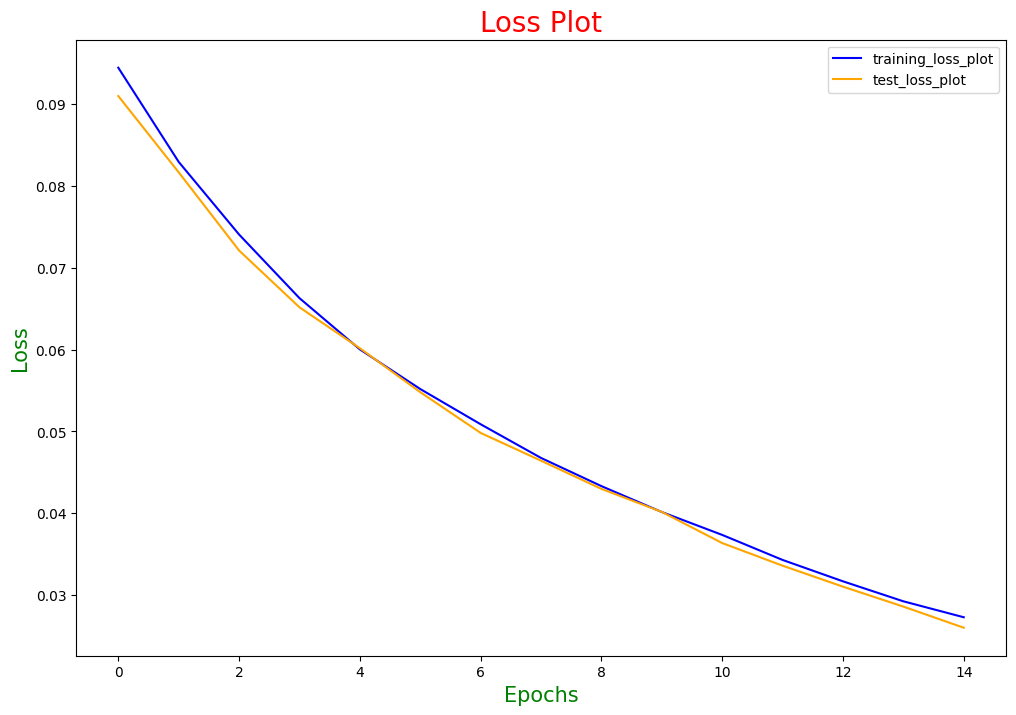

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))

plt.plot(loss_plot, color='blue', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='orange', label = 'test_loss_plot')
plt.xlabel('Epochs',fontsize = 15, color='green')
plt.ylabel('Loss',fontsize = 15, color='green')
plt.title('Loss Plot',fontsize = 20,color='Red')
plt.legend()
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights =decoder(dec_input, features, hidden)


        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id =tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [ ]:
def beam_evaluate(image, beam_index =1):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]
        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])



    return final_caption

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
features_shape = batch_features.shape[1]
attention_features_shape = batch_features.shape[0]

BLEU score: 70.13967267997694
Real Caption: she was determined to keep the rally going
Prediction Caption: she was determined to keep the shuttle


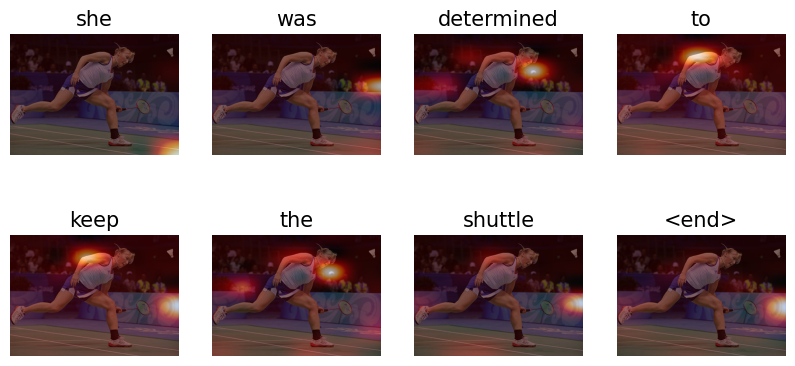

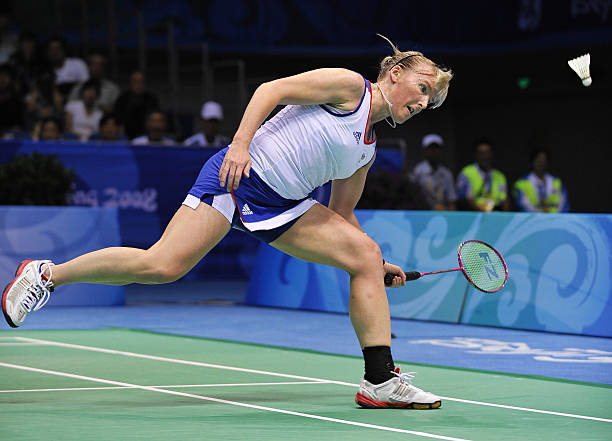

In [ ]:
rid = np.random.randint(0, len(path_test))
max_length=max_l
test_image = path_test[rid]


real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25) )#set your weights
print(f"BLEU score: {score*100}")
print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

she was determined to keep the shuttle


In [ ]:
import torch
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from io import BytesIO
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def download_image(image_url):
    """Download an image from a given URL and return it as a PIL Image."""
    response = requests.get(image_url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content)).convert('RGB')
    else:
        raise ValueError("Failed to download image")

def generate_caption(image):
    """Generate a caption for an image with a focus on actions and details."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)

    inputs = processor(images=image, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_length=50, num_beams=5, early_stopping=True, repetition_penalty=1.2)
    caption = processor.decode(output[0], skip_special_tokens=True).strip()
    return caption

def evaluate_and_score(image_url, real_caption):
    """Evaluate the generated caption and compute BLEU score."""
    image = download_image(image_url)
    predicted_caption = generate_caption(image)

    reference = [real_caption.split()]
    candidate = predicted_caption.split()

    smoothie = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference, candidate, weights=(0.5, 0.25, 0.15, 0.1), smoothing_function=smoothie)
    print('Real Caption:', real_caption)
    print('Predicted Caption:', predicted_caption)

    image.show()
    return predicted_caption, bleu_score

if __name__ == "__main__":
    image_url = "https://d26itsb5vlqdeq.cloudfront.net//image/B6EA08E3-C012-FC1D-76E16306F40B7528"
    real_caption = "two players are playing basketball"

    predicted_caption, score = evaluate_and_score(image_url, real_caption)



Real Caption: two players are playing basketball
Predicted Caption: there are two men playing a game of basketball on the court
